# Decision Trees
Supervised Learning Sec. 001</br>
Student: Bruno Morgado</br>
Student # 301-154-898

In [1]:
# Import necessary modules
import numpy as np
import pandas as pd
import time
import math
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

## Helper Functions

In [2]:
# Helper function
# Where to save the figures
PROJECT_ROOT_DIR = "."
ASSIGNMENT = "decision_trees"

def image_path(fig_id):
    path = os.path.join(PROJECT_ROOT_DIR, "images", ASSIGNMENT)
    if not os.path.exists(path):
        os.makedirs(path)
    return os.path.join(path, fig_id)
   

In [3]:
# Helper Function to plot confusion Matrix
def plot_confusion_matrix(confusion_matrix, y_limit: list, color_map: str):
    #Plot the confusion Matrix
    fig, ax = plt.subplots(figsize=(10,6))
    title = f'Confusion matrix: Decision-Trees'
    # create heatmap
    sns.heatmap(confusion_matrix, annot = True, cmap = color_map ,fmt='g')
    ax.xaxis.set_label_position("top")
    ax.set_ylim(y_limit)
    ax.xaxis.set_ticklabels(['0','1'])
    ax.yaxis.set_ticklabels(['0','1'])
    plt.title(title, fontsize=20, pad=10.0)
    plt.ylabel('Actual label', fontsize='large')
    plt.xlabel('Predicted label', fontsize='large')
    plt.tight_layout()

## Exploring the Student performance dataset

In [4]:
# Load student-por.csv
data_bruno = pd.read_csv('student-por.csv', sep=';')

In [5]:
# Show all columns in the dataset
pd.set_option('display.max_columns', None)

In [6]:
# Explore the first 5 rows of the dataset
data_bruno.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother           2          2         0       yes     no   no   
1  course   father           1          2         0        no    yes   no   
2   other   mother           1          2         0       yes     no   no   
3    home   mother           1          3         0        no    yes   no   
4    home   father           1          2         0        no    yes   no   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \
0         no     yes    yes       no       no       4         3      4     1   
1         no      no    yes      yes       no       5         3      3     1   
2         no     yes    yes      yes       no       4         3      2     2   
3        yes     yes    yes      yes      yes       3         2      2     1   
4         no     yes    yes       no       no       4         3      2     1   

   Walc  health  absences  G1  G2  G3  
0     1       3         4   0  11  11  
1     1       3         2   9  11  11  
2     3       3         6  12  13  12  
3     1       5         0  14  14  14  
4     2       5         0  11  13  13

In [7]:
# Explore the last 5 rows
data_bruno.tail()

school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
644     MS   F   19       R     GT3       T     2     3  services     other   
645     MS   F   18       U     LE3       T     3     1   teacher  services   
646     MS   F   18       U     GT3       T     1     1     other     other   
647     MS   M   17       U     LE3       T     3     1  services  services   
648     MS   M   18       R     LE3       T     3     2  services     other   

     reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
644  course   mother           1          3         1        no     no   no   
645  course   mother           1          2         0        no    yes   no   
646  course   mother           2          2         0        no     no   no   
647  course   mother           2          1         0        no     no   no   
648  course   mother           3          1         0        no     no   no   

    activities nursery higher internet romantic  famrel  freetime  goout  \
644        yes      no    yes      yes       no       5         4      2   
645         no     yes    yes      yes       no       4         3      4   
646        yes     yes    yes       no       no       1         1      1   
647         no      no    yes      yes       no       2         4      5   
648         no      no    yes      yes       no       4         4      1   

     Dalc  Walc  health  absences  G1  G2  G3  
644     1     2       5         4  10  11  10  
645     1     1       1         4  15  15  16  
646     1     1       5         6  11  12   9  
647     3     4       2         6  10  10  10  
648     3     4       5         4  10  11  11

In [8]:
# Get the list of all columns
data_bruno.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G1', 'G2', 'G3'],
      dtype='object')

In [9]:
data_bruno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

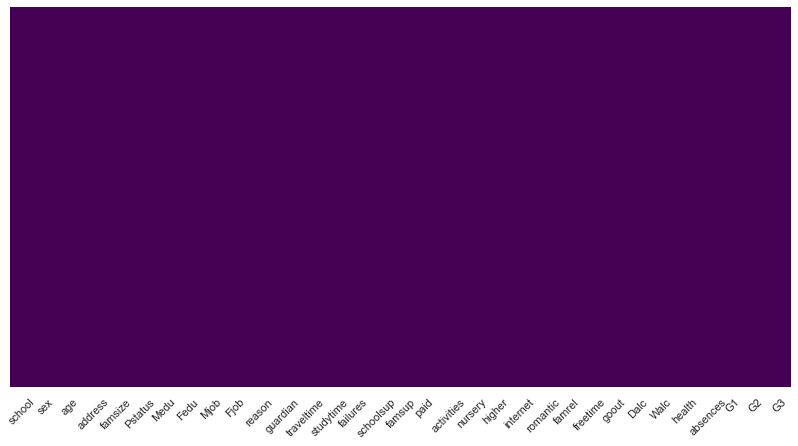

In [10]:
#Use a heatmap to visualize missing data
sns.set(rc={"figure.figsize":(14, 7)})
sns.heatmap(data_bruno.isna(),yticklabels=False,cbar=False,cmap='viridis')
plt.xticks(rotation = 45)
plt.show()

`The dataset seems to be integral, without any missing values.
In any case, columns with datatype 'object' need to be further
investigated.`

In [11]:
# Descriptive statistics
data_bruno.describe()

age        Medu        Fedu  traveltime   studytime    failures  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean    16.744222    2.514638    2.306626    1.568567    1.930663    0.221880   
std      1.218138    1.134552    1.099931    0.748660    0.829510    0.593235   
min     15.000000    0.000000    0.000000    1.000000    1.000000    0.000000   
25%     16.000000    2.000000    1.000000    1.000000    1.000000    0.000000   
50%     17.000000    2.000000    2.000000    1.000000    2.000000    0.000000   
75%     18.000000    4.000000    3.000000    2.000000    2.000000    0.000000   
max     22.000000    4.000000    4.000000    4.000000    4.000000    3.000000   

           famrel    freetime       goout        Dalc        Walc      health  \
count  649.000000  649.000000  649.000000  649.000000  649.000000  649.000000   
mean     3.930663    3.180277    3.184900    1.502311    2.280431    3.536210   
std      0.955717    1.051093    1.175766    0.924834    1.284380    1.446259   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    2.000000    1.000000    1.000000    2.000000   
50%      4.000000    3.000000    3.000000    1.000000    2.000000    4.000000   
75%      5.000000    4.000000    4.000000    2.000000    3.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

         absences          G1          G2          G3  
count  649.000000  649.000000  649.000000  649.000000  
mean     3.659476   11.399076   11.570108   11.906009  
std      4.640759    2.745265    2.913639    3.230656  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.000000   10.000000   10.000000   10.000000  
50%      2.000000   11.000000   11.000000   12.000000  
75%      6.000000   13.000000   13.000000   14.000000  
max     32.000000   19.000000   19.000000   19.000000

In [12]:
# Select categorical data
data_bruno_categorical = data_bruno.select_dtypes(include=['object'])

In [13]:
# First five rows of the categorical sub-dataset
data_bruno_categorical.head()

school sex address famsize Pstatus     Mjob      Fjob  reason guardian  \
0     GP   F       U     GT3       A  at_home   teacher  course   mother   
1     GP   F       U     GT3       T  at_home     other  course   father   
2     GP   F       U     LE3       T  at_home     other   other   mother   
3     GP   F       U     GT3       T   health  services    home   mother   
4     GP   F       U     GT3       T    other     other    home   father   

  schoolsup famsup paid activities nursery higher internet romantic  
0       yes     no   no         no     yes    yes       no       no  
1        no    yes   no         no      no    yes      yes       no  
2       yes     no   no         no     yes    yes      yes       no  
3        no    yes   no        yes     yes    yes      yes      yes  
4        no    yes   no         no     yes    yes       no       no

In [14]:
# Numeric columns
data_bruno_numeric = data_bruno.drop(data_bruno_categorical.columns, axis = 1)

In [15]:
# First five rows of the numeric sub_dataset
data_bruno_numeric.head()

age  Medu  Fedu  traveltime  studytime  failures  famrel  freetime  goout  \
0   18     4     4           2          2         0       4         3      4   
1   17     1     1           1          2         0       5         3      3   
2   15     1     1           1          2         0       4         3      2   
3   15     4     2           1          3         0       3         2      2   
4   16     3     3           1          2         0       4         3      2   

   Dalc  Walc  health  absences  G1  G2  G3  
0     1     1       3         4   0  11  11  
1     1     1       3         2   9  11  11  
2     2     3       3         6  12  13  12  
3     1     1       5         0  14  14  14  
4     1     2       5         0  11  13  13

In [16]:
# Get unique values and their count for each categorical column
for col in data_bruno_categorical.columns:
    ticks = (int)((30 - len(col)) / 2)
    print(f'\n{ticks * "*"} {col} {ticks * "*"}')
    print(data_bruno_categorical[col].value_counts())


************ school ************
GP    423
MS    226
Name: school, dtype: int64

************* sex *************
F    383
M    266
Name: sex, dtype: int64

*********** address ***********
U    452
R    197
Name: address, dtype: int64

*********** famsize ***********
GT3    457
LE3    192
Name: famsize, dtype: int64

*********** Pstatus ***********
T    569
A     80
Name: Pstatus, dtype: int64

************* Mjob *************
other       258
services    136
at_home     135
teacher      72
health       48
Name: Mjob, dtype: int64

************* Fjob *************
other       367
services    181
at_home      42
teacher      36
health       23
Name: Fjob, dtype: int64

************ reason ************
course        285
home          149
reputation    143
other          72
Name: reason, dtype: int64

*********** guardian ***********
mother    455
father    153
other      41
Name: guardian, dtype: int64

********** schoolsup **********
no     581
yes     68
Name: schoolsup, dtype: int64

*

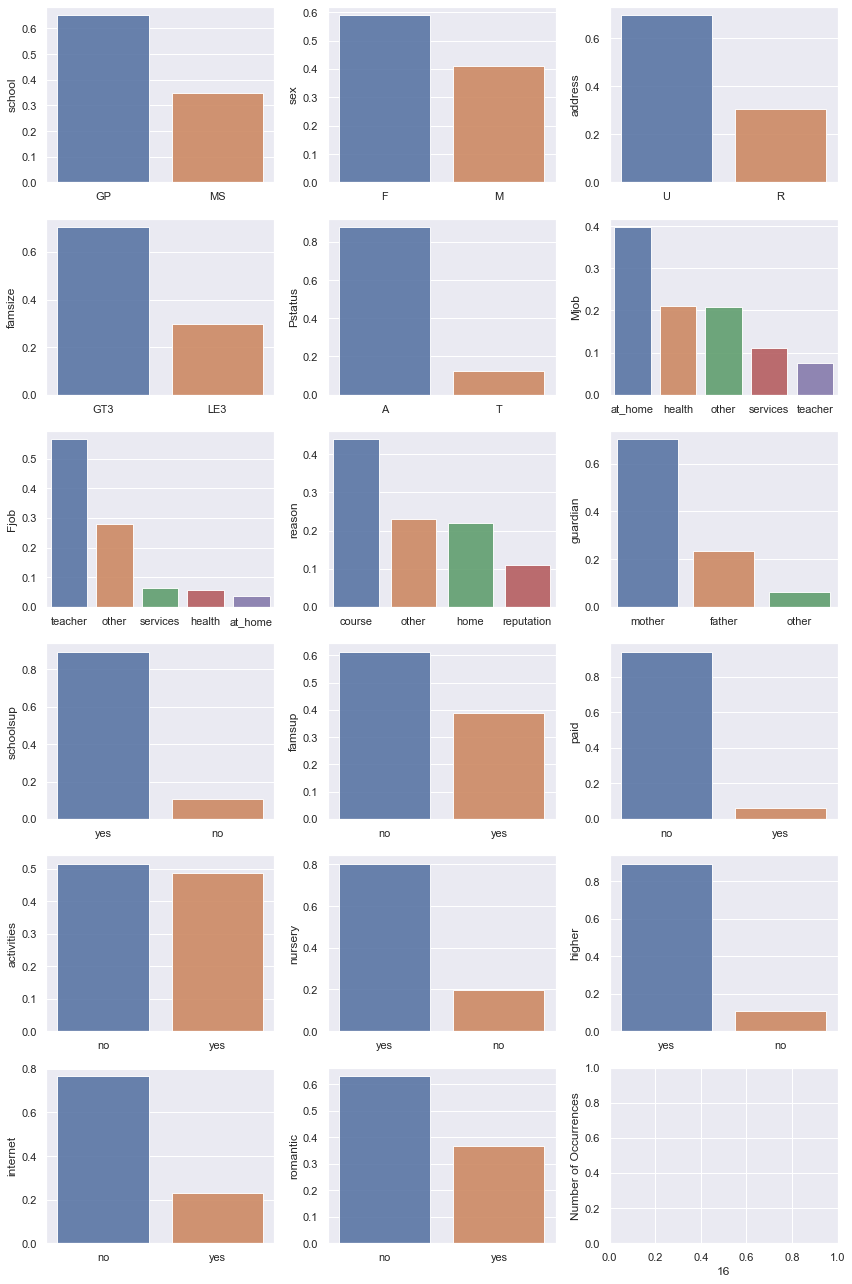

In [17]:
# Visual inspection 
nr_rows = 6
nr_cols = 3

cols_categories = data_bruno_categorical.columns
idx = 0

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)

for r in range(0,nr_rows):
    for c in range(0, nr_cols):  
        col = r*nr_cols+c
        if col < len(cols_categories):
            x = data_bruno_categorical[cols_categories[idx]].unique()
            y = data_bruno_categorical[cols_categories[idx]].value_counts()/len(data_bruno_categorical[cols_categories[idx]])
            idx += 1
            sns.set(style="darkgrid")
            sns.barplot(x = x, y = y, alpha=0.9,ax = axs[r][c])
            plt.ylabel('Number of Occurrences', fontsize=12)
            plt.xlabel(col, fontsize=12)
plt.tight_layout()    
plt.show()


In [18]:
# Instantiate a make_column_transformer to transform the categorical variables
# and leave the other columns as they are
categorical_cols = data_bruno_categorical.columns
transformer = make_column_transformer(
    (OneHotEncoder(), categorical_cols),
    remainder='passthrough',
    verbose_feature_names_out=False)

In [19]:
# Combine the three target variables into one categorical dependet variable
data_bruno['pass_bruno'] = np.where(data_bruno[['G1', 'G2', 'G3']].sum(axis=1) >= 35, 1, 0)

In [20]:
# Drop the original output variables
data_bruno.drop(['G1', 'G2', 'G3'], axis = 1, inplace = True)

In [21]:
# Inspect the transformed dataset
data_bruno.head()

school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

   reason guardian  traveltime  studytime  failures schoolsup famsup paid  \
0  course   mother           2          2         0       yes     no   no   
1  course   father           1          2         0        no    yes   no   
2   other   mother           1          2         0       yes     no   no   
3    home   mother           1          3         0        no    yes   no   
4    home   father           1          2         0        no    yes   no   

  activities nursery higher internet romantic  famrel  freetime  goout  Dalc  \
0         no     yes    yes       no       no       4         3      4     1   
1         no      no    yes      yes       no       5         3      3     1   
2         no     yes    yes      yes       no       4         3      2     2   
3        yes     yes    yes      yes      yes       3         2      2     1   
4         no     yes    yes       no       no       4         3      2     1   

   Walc  health  absences  pass_bruno  
0     1       3         4           0  
1     1       3         2           0  
2     3       3         6           1  
3     1       5         0           1  
4     2       5         0           1

In [22]:
# Store the dataset in .csv format
# data_transformed.to_csv('transformed.csv')

In [23]:
# Separate features from target variables
features_bruno = data_bruno.drop('pass_bruno', axis = 1)
target_variable_bruno = data_bruno['pass_bruno']

In [24]:
features_bruno.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [25]:
target_variable_bruno.info()

<class 'pandas.core.series.Series'>
RangeIndex: 649 entries, 0 to 648
Series name: pass_bruno
Non-Null Count  Dtype
--------------  -----
649 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [26]:
# Number of unique values in the target variables
target_variable_bruno.value_counts()

1    328
0    321
Name: pass_bruno, dtype: int64

In [27]:
proportion = target_variable_bruno.value_counts()/len(target_variable_bruno)

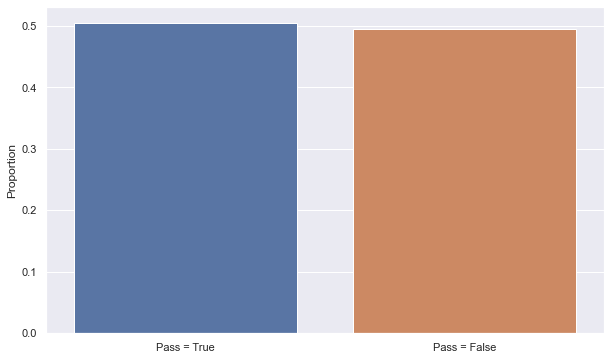

In [28]:
# Check for imbalanced target variables
plt.figure(figsize = (10,6))
sns.barplot(x = [0, 1], y = proportion)
plt.xticks(np.arange(2),('Pass = True', 'Pass = False'))
plt.ylabel('Proportion')
plt.show()

In [29]:
# Instantiate the decision tree classifier
clf_bruno = DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [30]:
# Create a pipeline to streamline the transformation and prediction process
pipeline_bruno = Pipeline([
    ('col_transformer', transformer),
    ('clf_bruno', clf_bruno)
    ])

In [31]:
# Split the dataset into training and test datasets
X_train_bruno, X_test_bruno, y_train_bruno, y_test_bruno = train_test_split(features_bruno, target_variable_bruno, test_size=0.20, random_state=98)

In [32]:
# Fit the pipeline onto the training data
pipeline_bruno.fit(X_train_bruno, y_train_bruno)

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('clf_bruno',
                 DecisionTreeClassifier(criterion='entropy', max_depth=5))])

In [33]:
# Get 5-fold cross-validation scores on the training datase
scores = cross_val_score(pipeline_bruno,
                        X_train_bruno,
                        y_train_bruno,
                        cv=10,
                        n_jobs=-1,
                        verbose=1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.7s finished


In [34]:
print(scores)

[0.65384615 0.63461538 0.55769231 0.69230769 0.65384615 0.63461538
 0.71153846 0.67307692 0.69230769 0.54901961]


In [35]:
# Get the mean accuracy score
print(scores.mean())

0.6452865761689291


In [36]:
# Export a visual of the Decision Tree
export_graphviz(
clf_bruno,
out_file=image_path("student_por_tree.dot"),
feature_names=transformer.get_feature_names_out(),
class_names = ['0', '1'],
rounded=True,
filled=True
)

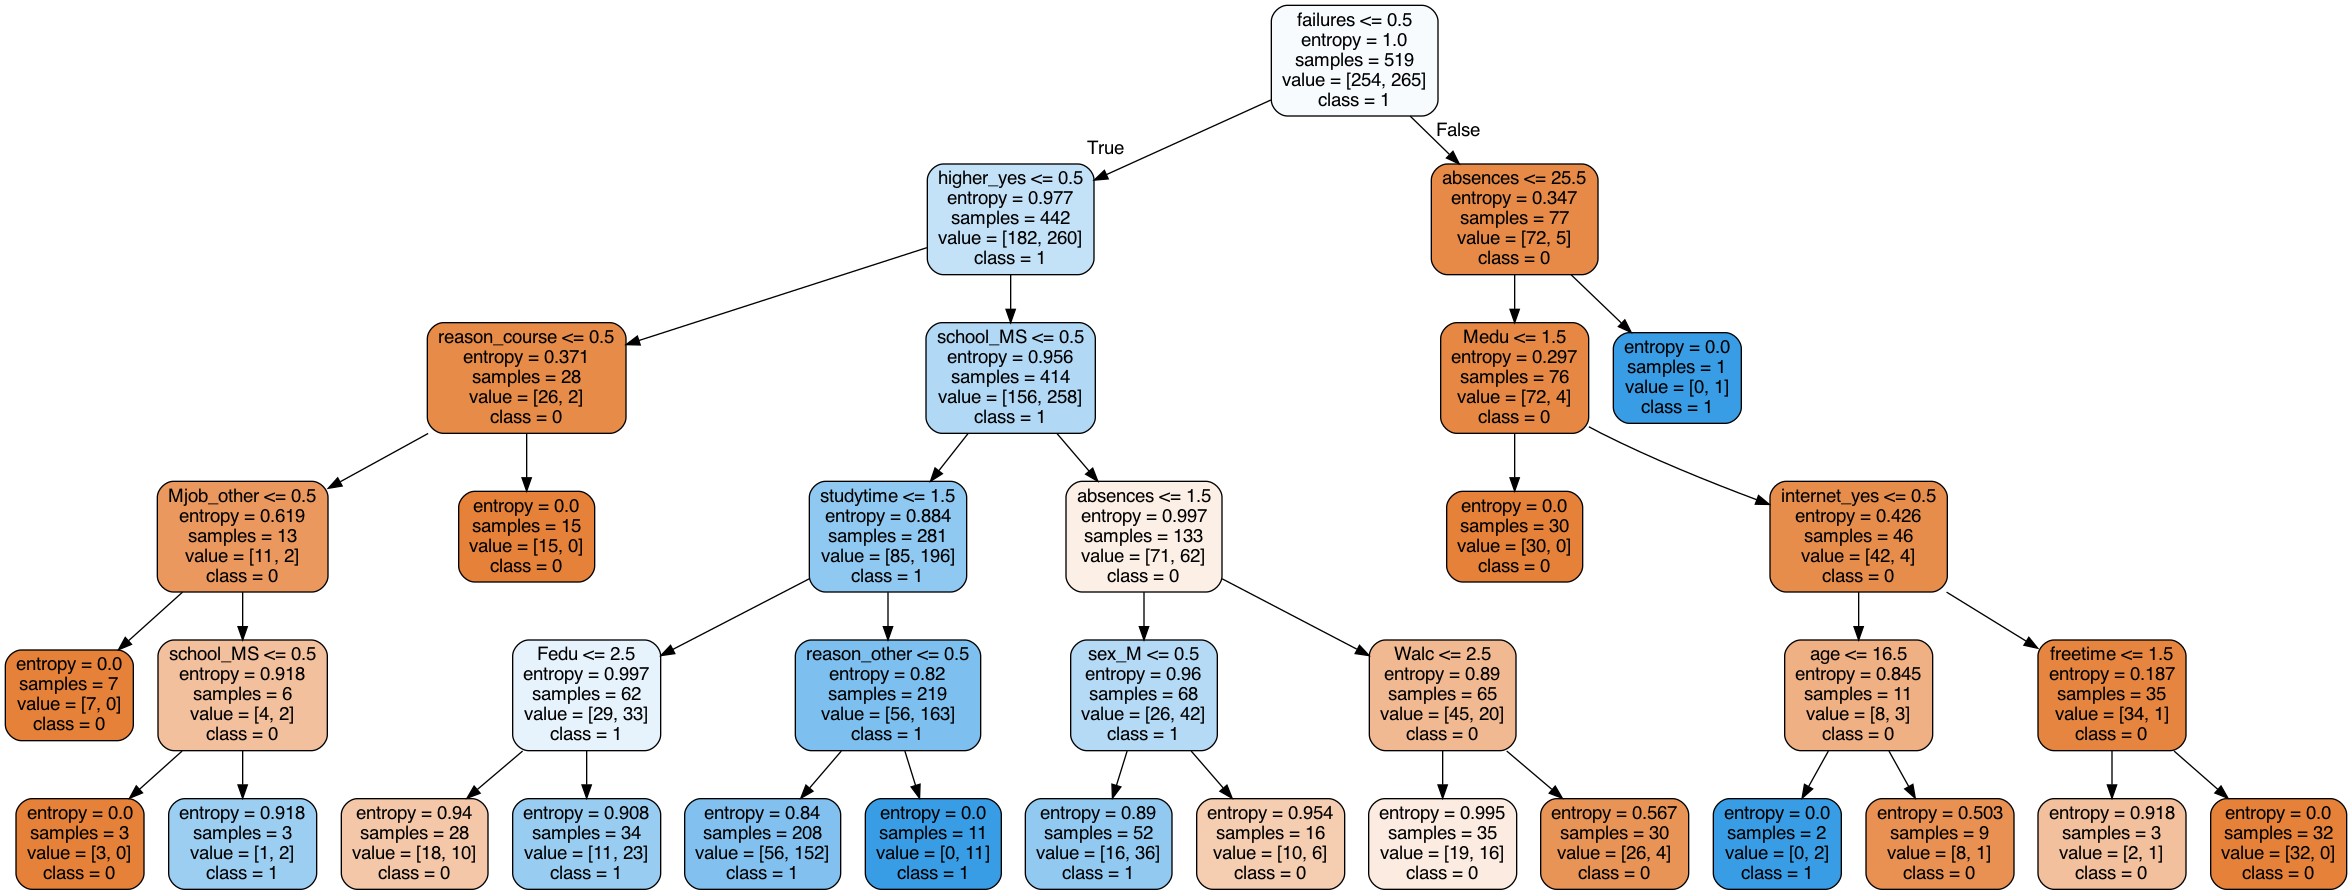

In [37]:
print(f'Training Score: {round(pipeline_bruno.score(X_train_bruno, y_train_bruno) * 100, 4)}%')

Training Score: 76.4933%


In [38]:
print(f'Test Score: {round(pipeline_bruno.score(X_test_bruno, y_test_bruno) * 100, 4)}%')

Test Score: 69.2308%


In [39]:
# Make predictions
y_pred = pipeline_bruno.predict(X_test_bruno)

In [40]:
cm = confusion_matrix(y_test_bruno, y_pred)

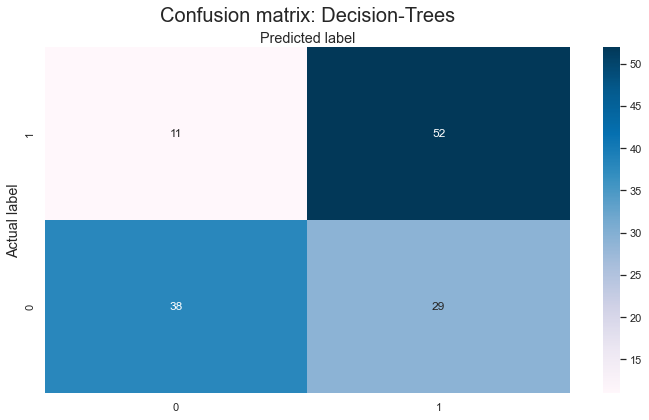

In [41]:
# Plot Confusion Matrix
plot_confusion_matrix(cm, [0,2], 'PuBu')

In [42]:
print(classification_report(y_test_bruno, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.57      0.66        67
           1       0.64      0.83      0.72        63

    accuracy                           0.69       130
   macro avg       0.71      0.70      0.69       130
weighted avg       0.71      0.69      0.69       130



precision means what percentage of the positive predictions made were actually correct.

`TP/(TP+FP)`

Recall in simple terms means, what percentage of actual positive predictions were correctly classified by the classifier.

`TP/(TP+FN)`

F1 score can also be described as the harmonic mean or weighted average of precision and recall.

`2x((precision x recall) / (precision + recall))`

## Fine-tuning the model

In [43]:
parameters={'clf_bruno__min_samples_split' : range(10,300,20),
            'clf_bruno__max_depth': range(1,30,2),
            'clf_bruno__min_samples_leaf':range(1,15,3)}

In [44]:
parameters

{'clf_bruno__min_samples_split': range(10, 300, 20),
 'clf_bruno__max_depth': range(1, 30, 2),
 'clf_bruno__min_samples_leaf': range(1, 15, 3)}

In [45]:
# Create a RandomizedSearchCV object
grid_search_bruno = RandomizedSearchCV(estimator = pipeline_bruno,
                                       param_distributions = parameters,
                                       scoring = 'accuracy',
                                       cv = 5,
                                       n_iter = 7,
                                       refit = True,
                                       n_jobs = -1,
                                       verbose = 3)

In [46]:
# Fitting RandomizedSearch onto the the training data
grid_search_bruno.fit(X_train_bruno, y_train_bruno)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object'))],
                                                                verbose_feature_names_out=False)),
                                             ('clf_bruno',
                                              DecisionTreeClassifier(criterion='entropy',
                                                                     max_dept

In [47]:
# Best hyperparameters
print("tuned hpyerparameters :(best parameters) \n", grid_search_bruno.best_params_)

tuned hpyerparameters :(best parameters) 
 {'clf_bruno__min_samples_split': 150, 'clf_bruno__min_samples_leaf': 7, 'clf_bruno__max_depth': 3}


In [48]:
# Store the best model
best_model = grid_search_bruno.best_estimator_

In [49]:
best_model.score(X_train_bruno, y_train_bruno)

0.7032755298651252

In [50]:
best_model

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('clf_bruno',
                 DecisionTreeClassifier(criterion='entropy', max_depth=3,
                                        min_samples_leaf=7,
                                        min_samples_split=150))])

In [51]:
# Make new predictions with the tuned model
final_pred = best_model.predict(X_test_bruno)

In [52]:
best_model.score(X_test_bruno, y_test_bruno)

0.7384615384615385

In [53]:
# Print the classification Report
print('\t\tClassification Report\n\n',classification_report(y_test_bruno, final_pred))

		Classification Report

               precision    recall  f1-score   support

           0       0.82      0.63      0.71        67
           1       0.68      0.86      0.76        63

    accuracy                           0.74       130
   macro avg       0.75      0.74      0.74       130
weighted avg       0.76      0.74      0.74       130



In [54]:
# Import joblib to save the model
import joblib

In [55]:
joblib.dump(best_model, "DT_model.pkl")

['DT_model.pkl']

In [56]:
joblib.dump(pipeline_bruno, "full_pipeline.pkl")

['full_pipeline.pkl']

In [57]:
import dill

In [58]:
# Store the session
dill.dump_session('notebook_env.db')

## Additional test with - Cost Complexity Pruning

In [59]:
# Adding ccp_alpha to the parameters grid
parameters_pruning={'clf_bruno__min_samples_split' : range(10,300,20),
                    'clf_bruno__max_depth': range(1,30,2),
                    'clf_bruno__min_samples_leaf':range(1,15,3),
                    'clf_bruno__ccp_alpha': np.arange(0, 1.005, 0.005)}

In [60]:
# Create a RandomizedSearchCV object
grid_search_bruno_pruning = RandomizedSearchCV(estimator = pipeline_bruno,
                                       param_distributions = parameters_pruning,
                                       scoring = 'accuracy',
                                       cv = 5,
                                       n_iter = 10000,
                                       refit = True,
                                       n_jobs = -1,
                                       verbose = 3)

In [61]:
# Fitting RandomizedSearch onto the the training data
grid_search_bruno_pruning.fit(X_train_bruno, y_train_bruno)

Fitting 5 folds for each of 10000 candidates, totalling 50000 fits
[CV 1/5] END clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.625 total time=   0.0s
[CV 3/5] END clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.683 total time=   0.0s
[CV 4/5] END clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.683 total time=   0.1s
[CV 2/5] END clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.654 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.97, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.715, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.93, clf_bruno__max_depth=29, clf_b

[CV 1/5] END clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=150;, score=0.692 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.89, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.645, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.935, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.935, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.935, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.9400000000000001, clf

[CV 2/5] END clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.606 total time=   0.0s
[CV 1/5] END clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.683 total time=   0.0s
[CV 4/5] END clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.721 total time=   0.0s
[CV 1/5] END clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=250;, score=0.692 total time=   0.1s
[CV 3/5] END clf_bruno__ccp_alpha=0.89, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.89, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.77, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.5

[CV 3/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.255, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.255, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.255, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno

[CV 3/5] END clf_bruno__ccp_alpha=0.72, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.72, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.72, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.115, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.115, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.587 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.96, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__cc

[CV 2/5] END clf_bruno__ccp_alpha=0.85, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.85, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.85, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.85, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.135, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.135, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.587 total time=   0.0s
[CV 1/5] END clf_bruno__cc

[CV 4/5] END clf_bruno__ccp_alpha=0.985, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.985, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.685, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.685, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.685, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.685, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__

[CV 2/5] END clf_bruno__ccp_alpha=0.09, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.09, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.625 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.09, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.09, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.185, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.185, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_al

[CV 2/5] END clf_bruno__ccp_alpha=0.985, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__cc

[CV 2/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.385, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.385, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__

[CV 5/5] END clf_bruno__ccp_alpha=0.905, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.85, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.85, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.76, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.9500000000000001, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.9500000000000001, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s

[CV 2/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.4, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.885, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_al

[CV 1/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.515 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.28500000000000003, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 

[CV 2/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.895, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.895, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.81, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.81, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_

[CV 5/5] END clf_bruno__ccp_alpha=0.27, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.654 total time=   0.1s
[CV 3/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.712 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.721 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.87, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha

[CV 5/5] END clf_bruno__ccp_alpha=0.965, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.9, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.9, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.625, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.625, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_al

[CV 3/5] END clf_bruno__ccp_alpha=0.74, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.13, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.13, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.13, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__

[CV 3/5] END clf_bruno__ccp_alpha=0.38, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.38, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.38, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.34500000000000003, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.34500000000000003, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.34500000000000003, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total ti

[CV 1/5] END clf_bruno__ccp_alpha=0.87, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.87, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.325, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.325, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.325, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.44, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__

[CV 5/5] END clf_bruno__ccp_alpha=0.605, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.135, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.135, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.135, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.135, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.135, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_brun

[CV 1/5] END clf_bruno__ccp_alpha=0.39, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.39, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.88, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.88, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.88, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp

[CV 5/5] END clf_bruno__ccp_alpha=0.88, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_

[CV 5/5] END clf_bruno__ccp_alpha=0.805, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.33, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.33, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.33, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.33, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.33, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alph

[CV 5/5] END clf_bruno__ccp_alpha=0.485, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.915, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.255, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.11, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.11, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.11, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alp

[CV 5/5] END clf_bruno__ccp_alpha=0.835, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.673 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.606 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.673 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.712 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.06, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alp

[CV 2/5] END clf_bruno__ccp_alpha=0.59, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.59, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_

[CV 4/5] END clf_bruno__ccp_alpha=0.77, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno_

[CV 2/5] END clf_bruno__ccp_alpha=0.135, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.135, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.135, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.025, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.025, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.654 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.025, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.712 total time=   0.0s
[CV 4/5] END clf_br

[CV 4/5] END clf_bruno__ccp_alpha=0.9400000000000001, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.9400000000000001, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.035, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.035, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.625 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.035, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.750 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.035, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.673 total time=  

[CV 3/5] END clf_bruno__ccp_alpha=0.32, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.32, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.32, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__c

[CV 5/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.48, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.48, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.48, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.48, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alp

[CV 2/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.335, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.335, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_b

[CV 4/5] END clf_bruno__ccp_alpha=0.45, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.18, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.18, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=

[CV 2/5] END clf_bruno__ccp_alpha=0.9450000000000001, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.9450000000000001, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.9450000000000001, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.9450000000000001, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=70;, score=0.740 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.41000000000000003, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_

[CV 4/5] END clf_bruno__ccp_alpha=0.675, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.55, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.55, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.55, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.9450000000000001, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.9450000000000001, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5

[CV 2/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=190;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.035, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.035, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_

[CV 5/5] END clf_bruno__ccp_alpha=0.065, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.51, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.51, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.51, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.51, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.51, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__cc

[CV 4/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.9400000000000001, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.975, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.64, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.64, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END c

[CV 3/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.465, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.465, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.525, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_brun

[CV 5/5] END clf_bruno__ccp_alpha=0.97, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.855, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 5/5] END clf_brun

[CV 5/5] END clf_bruno__ccp_alpha=0.66, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.425, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.315, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.315, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.315, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.315, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp

[CV 4/5] END clf_bruno__ccp_alpha=0.52, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.52, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.37, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.37, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.37, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.37, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_al

[CV 4/5] END clf_bruno__ccp_alpha=0.635, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.635, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.315, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.315, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.315, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp

[CV 5/5] END clf_bruno__ccp_alpha=0.635, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.355, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.355, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.355, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.355, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.355, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno

[CV 1/5] END clf_bruno__ccp_alpha=0.465, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s[CV 2/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.625 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.58, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha

[CV 3/5] END clf_bruno__ccp_alpha=0.265, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.395, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__

[CV 1/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.16, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha

[CV 4/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.689 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.915, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.915, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.915, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.915, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__cc

[CV 1/5] END clf_bruno__ccp_alpha=0.835, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.835, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.835, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.5750000000000001, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.5750000000000001, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.5750000000000001, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=30;, score=0.510 total

[CV 1/5] END clf_bruno__ccp_alpha=0.145, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.145, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.145, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.145, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.145, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.61, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno_

[CV 5/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.275, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.275, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.275, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.275, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.45, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp

[CV 5/5] END clf_bruno__ccp_alpha=0.12, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.47000000000000003, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.47000000000000003, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.485, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.65, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.65, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.510 total time=   0

[CV 2/5] END clf_bruno__ccp_alpha=0.655, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.655, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.655, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.655, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.495, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.495, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__

[CV 3/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.22, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.22, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.22, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_

[CV 5/5] END clf_bruno__ccp_alpha=0.595, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.06, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.06, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.06, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.625 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.06, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.596 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.055, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=90;, score=0.750 total time=   0.0s
[CV 4/5] END clf_bruno__cc

[CV 3/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.935, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.935, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.935, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.692 total time=   0.0s
[CV 2/5] END clf_br

[CV 5/5] END clf_bruno__ccp_alpha=0.88, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.71, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.71, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.71, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.71, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.71, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=

[CV 1/5] END clf_bruno__ccp_alpha=0.355, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.81, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.525, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.525, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.525, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.525, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno_

[CV 2/5] END clf_bruno__ccp_alpha=0.55, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.55, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.55, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.55, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.425, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.425, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__

[CV 2/5] END clf_bruno__ccp_alpha=0.805, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.805, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.805, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.805, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.715, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.715, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno

[CV 5/5] END clf_bruno__ccp_alpha=0.005, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=30;, score=0.641 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.43, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.43, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.43, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.23, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.23, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alp

[CV 2/5] END clf_bruno__ccp_alpha=0.0, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.606 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.28, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.515, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_a

[CV 1/5] END clf_bruno__ccp_alpha=0.28, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.28, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.28, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.28, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_al

[CV 3/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.605, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.38, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.8200000000000001, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] E

[CV 1/5] END clf_bruno__ccp_alpha=0.275, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.275, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.805, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.805, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.735, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.735, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bru

[CV 5/5] END clf_bruno__ccp_alpha=0.435, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.81, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.81, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.81, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.81, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.525, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_a

[CV 1/5] END clf_bruno__ccp_alpha=0.4, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.905, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.905, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.905, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.8250000000000001, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.8250000000000001, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s

[CV 1/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.692 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.56, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.195, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.195, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.195, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.195, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__

[CV 4/5] END clf_bruno__ccp_alpha=0.81, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.81, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno

[CV 2/5] END clf_bruno__ccp_alpha=0.255, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.255, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.455, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 4/5] END clf_br

[CV 3/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_

[CV 4/5] END clf_bruno__ccp_alpha=0.27, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.27, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.93, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.93, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.93, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.93, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_al

[CV 4/5] END clf_bruno__ccp_alpha=0.935, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.935, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.26, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.26, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.26, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.26, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__

[CV 2/5] END clf_bruno__ccp_alpha=0.17, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.17, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.17, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.17, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.005, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.635 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.895, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp

[CV 4/5] END clf_bruno__ccp_alpha=0.8200000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.8200000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.085, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.085, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.085, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.625 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.76, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[C

[CV 4/5] END clf_bruno__ccp_alpha=0.195, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.195, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.9400000000000001, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.9400000000000001, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.9400000000000001, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.9400000000000001, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=70;, score=0.5

[CV 3/5] END clf_bruno__ccp_alpha=0.74, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.74, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.74, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.1, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.1, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=

[CV 2/5] END clf_bruno__ccp_alpha=0.20500000000000002, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.625 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.750 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.689 total time=   0.0s
[CV 1/5]

[CV 1/5] END clf_bruno__ccp_alpha=0.88, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.75, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.75, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp

[CV 2/5] END clf_bruno__ccp_alpha=0.555, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.555, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.555, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.265, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.41500000000000004, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.41500000000000004, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time= 

[CV 2/5] END clf_bruno__ccp_alpha=0.51, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.51, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.51, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.51, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.17500000000000002, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.17500000000000002, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=  

[CV 5/5] END clf_bruno__ccp_alpha=0.665, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.62, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.62, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.62, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.62, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.62, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno_

[CV 3/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.09, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.09, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.09, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.625 total

[CV 2/5] END clf_bruno__ccp_alpha=0.65, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.65, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.65, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.65, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.225, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.225, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__

[CV 2/5] END clf_bruno__ccp_alpha=0.89, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.8150000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.8150000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.8150000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.055, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.055, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.587 tot

[CV 3/5] END clf_bruno__ccp_alpha=0.9450000000000001, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.9450000000000001, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.9450000000000001, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.08, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.08, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.587 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.335, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.510 total tim

[CV 1/5] END clf_bruno__ccp_alpha=0.86, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.86, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.1s
[CV 3/5] END clf_bruno__ccp_alpha=0.86, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.86, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.86, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.36, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.1s
[CV 1/5] END clf_bruno__ccp_a

[CV 3/5] END clf_bruno__ccp_alpha=0.055, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.750 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.055, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.055, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.1, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.1, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.1, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.625 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alp

[CV 3/5] END clf_bruno__ccp_alpha=0.265, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.265, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.265, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=190;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno

[CV 4/5] END clf_bruno__ccp_alpha=0.625, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.625, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.37, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.37, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.37, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.37, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_

[CV 2/5] END clf_bruno__ccp_alpha=0.905, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.905, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.905, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.905, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.52, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.64, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_a

[CV 5/5] END clf_bruno__ccp_alpha=0.5750000000000001, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.27, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.27, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.72, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.72, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.72, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 4/5] END clf_

[CV 2/5] END clf_bruno__ccp_alpha=0.245, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.245, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.245, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.375, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.375, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.375, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno

[CV 5/5] END clf_bruno__ccp_alpha=0.77, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.20500000000000002, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.20500000000000002, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.625 total time=   

[CV 5/5] END clf_bruno__ccp_alpha=0.755, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.5750000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.5750000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.5750000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.5750000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.5750000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_s

[CV 2/5] END clf_bruno__ccp_alpha=0.77, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.77, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.77, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.77, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.16, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.16, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__cc

[CV 3/5] END clf_bruno__ccp_alpha=0.525, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.525, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.525, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.3, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.3, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.3, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alp

[CV 3/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.04, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.04, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.625 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.04, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.750 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alp

[CV 2/5] END clf_bruno__ccp_alpha=0.76, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.7000000000000001, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.7000000000000001, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.7000000000000001, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.05, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.05, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.625 total t

[CV 1/5] END clf_bruno__ccp_alpha=0.47500000000000003, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.47500000000000003, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.47500000000000003, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.47500000000000003, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=13, 

[CV 1/5] END clf_bruno__ccp_alpha=0.23, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.23, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.23, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.23, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.095, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=30;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.795, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alph

[CV 3/5] END clf_bruno__ccp_alpha=0.32, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.32, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.32, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.085, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.644 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.425, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.425, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_

[CV 5/5] END clf_bruno__ccp_alpha=0.795, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.795, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.795, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.795, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.795, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.795, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno_

[CV 1/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.44, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_

[CV 4/5] END clf_bruno__ccp_alpha=0.105, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.105, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.1s
[CV 4/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno

[CV 5/5] END clf_bruno__ccp_alpha=0.41000000000000003, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.64, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.64, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.64, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.64, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.64, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.515 total time=   0.0s
[CV 1/5] END

[CV 4/5] END clf_bruno__ccp_alpha=0.41000000000000003, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.9550000000000001, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.18, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.18, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.18, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.18, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0

[CV 3/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno

[CV 3/5] END clf_bruno__ccp_alpha=0.775, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.775, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.775, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.2, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.2, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.2, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=

[CV 2/5] END clf_bruno__ccp_alpha=0.485, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.485, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.1s
[CV 4/5] END clf_bruno__ccp_alpha=0.485, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.485, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.3, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.3, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_al

[CV 3/5] END clf_bruno__ccp_alpha=0.555, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.555, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.555, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.625 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.750 total time=   0.0s
[CV 4/5] END clf_br

[CV 1/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.545, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.005, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=10;, score=0.692 total time=   0.0s
[CV 5/5] END clf_

[CV 1/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.625 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.750 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.689 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_

[CV 1/5] END clf_bruno__ccp_alpha=0.7000000000000001, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.7000000000000001, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.7000000000000001, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.075, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.075, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.075, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.625 to

[CV 4/5] END clf_bruno__ccp_alpha=0.6950000000000001, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.6950000000000001, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.654 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.635 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.769 total time=   0.1s
[CV 4/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.721 total time=   0.0s


[CV 5/5] END clf_bruno__ccp_alpha=0.73, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=190;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.335, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.335, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.335, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__cc

[CV 5/5] END clf_bruno__ccp_alpha=0.845, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.215, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.215, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.885, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.885, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.885, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp

[CV 2/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.31, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.31, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__c

[CV 2/5] END clf_bruno__ccp_alpha=0.17, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.84, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.84, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.84, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.84, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.005, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alp

[CV 5/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.84, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.875, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.875, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.875, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=90;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__cc

[CV 2/5] END clf_bruno__ccp_alpha=0.5650000000000001, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.5650000000000001, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.5650000000000001, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.5650000000000001, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=10;, sco

[CV 3/5] END clf_bruno__ccp_alpha=0.28, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.28, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.28, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.52, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.52, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.52, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_

[CV 4/5] END clf_bruno__ccp_alpha=0.78, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.78, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.165, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.165, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.165, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.165, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.1s
[CV 5/5] END clf_bruno__

[CV 1/5] END clf_bruno__ccp_alpha=0.76, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.76, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.1s
[CV 3/5] END clf_bruno__ccp_alpha=0.76, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.76, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.76, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.73, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__

[CV 3/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.750 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.596 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.38, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.38, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.38, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.325, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__cc

[CV 2/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.587 total time=   0.1s
[CV 3/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.625 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.17500000000000002, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.17500000000000002, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[C

[CV 3/5] END clf_bruno__ccp_alpha=0.26, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.26, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.1s
[CV 5/5] END clf_bruno__ccp_alpha=0.335, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 tota

[CV 1/5] END clf_bruno__ccp_alpha=0.23500000000000001, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.23500000000000001, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.23500000000000001, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.72, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.72, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.72, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.510 to

[CV 2/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.1s
[CV 4/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.495, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.495, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp

[CV 1/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.425, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp

[CV 1/5] END clf_bruno__ccp_alpha=0.23, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.23, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.23, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.625 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.750 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.045, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=130;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_

[CV 1/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.765, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.295, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__cc

[CV 2/5] END clf_bruno__ccp_alpha=0.105, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.105, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.105, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.105, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.755, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.755, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__cc

[CV 3/5] END clf_bruno__ccp_alpha=0.6900000000000001, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.6900000000000001, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.6900000000000001, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.065, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.065, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.065, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.625 to

[CV 1/5] END clf_bruno__ccp_alpha=0.8, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.8, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.62, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha

[CV 1/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.39, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_

[CV 3/5] END clf_bruno__ccp_alpha=0.035, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.750 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.035, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.673 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.035, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=230;, score=0.650 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.255, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.255, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.13, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno_

[CV 4/5] END clf_bruno__ccp_alpha=0.7000000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.7000000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.24, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[C

[CV 3/5] END clf_bruno__ccp_alpha=0.76, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.76, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.095, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.625 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.095, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.596 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.095, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=110;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.105, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno_

[CV 3/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.93, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.93, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.93, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_

[CV 3/5] END clf_bruno__ccp_alpha=0.41500000000000004, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.41500000000000004, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.41500000000000004, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.195, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.195, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.23, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=270;, score=0.510 t

[CV 5/5] END clf_bruno__ccp_alpha=0.78, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.755, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.755, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.755, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.755, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.755, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.515 total time=   0.0s
[CV 1/5] END clf_b

[CV 3/5] END clf_bruno__ccp_alpha=0.885, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.22, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.22, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.505, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_

[CV 4/5] END clf_bruno__ccp_alpha=0.03, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=270;, score=0.673 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.635, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.635, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.635, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.635, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.635, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno

[CV 1/5] END clf_bruno__ccp_alpha=0.455, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.75, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.75, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.75, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.75, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=90;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.07, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=250;, score=0.644 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alph

[CV 5/5] END clf_bruno__ccp_alpha=0.525, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.63, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.72, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alph

[CV 3/5] END clf_bruno__ccp_alpha=0.87, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.87, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.87, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.04, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.04, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.625 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.04, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.750 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_

[CV 5/5] END clf_bruno__ccp_alpha=0.605, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.71, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.71, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.71, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.71, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.71, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alph

[CV 1/5] END clf_bruno__ccp_alpha=0.31, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.31, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.63, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.63, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.63, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.663 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.

[CV 3/5] END clf_bruno__ccp_alpha=0.405, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.405, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.315, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.315, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.22, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.22, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__cc

[CV 5/5] END clf_bruno__ccp_alpha=0.31, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=70;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.53, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.53, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.53, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.53, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.53, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_

[CV 3/5] END clf_bruno__ccp_alpha=0.9550000000000001, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.9550000000000001, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.9550000000000001, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.915, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.915, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.47000000000000003, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=

[CV 3/5] END clf_bruno__ccp_alpha=0.975, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.975, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.975, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.66, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.66, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.66, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno

[CV 3/5] END clf_bruno__ccp_alpha=0.14, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.14, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.14, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=50;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.495, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.495, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.495, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alp

[CV 3/5] END clf_bruno__ccp_alpha=0.375, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.375, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.375, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.965, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.965, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.195, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 2/5] END clf_brun

[CV 2/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=1.0, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.20500000000000002, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] E

[CV 3/5] END clf_bruno__ccp_alpha=0.8150000000000001, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.8150000000000001, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.8150000000000001, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=250;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.15, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=150;, score=0.510 to

[CV 3/5] END clf_bruno__ccp_alpha=0.245, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.245, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.245, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=270;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.125, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.125, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.587 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.125, clf_bruno__max_depth=5, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__c

[CV 3/5] END clf_bruno__ccp_alpha=0.785, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.785, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.41500000000000004, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.41500000000000004, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.41500000000000004, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.41500000000000004, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170

[CV 1/5] END clf_bruno__ccp_alpha=0.46, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.46, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.46, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.46, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.46, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=250;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.75, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=50;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_

[CV 5/5] END clf_bruno__ccp_alpha=0.635, clf_bruno__max_depth=27, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.325, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=1, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=170;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.79, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=

[CV 4/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.745, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=290;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.8150000000000001, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.53, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.625, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.625, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] 

[CV 1/5] END clf_bruno__ccp_alpha=0.13, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.49, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.49, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.49, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.275, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.275, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp

[CV 3/5] END clf_bruno__ccp_alpha=0.705, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=250;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.28500000000000003, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.28500000000000003, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.28500000000000003, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.28500000000000003, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.905, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_spl

[CV 4/5] END clf_bruno__ccp_alpha=0.375, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.375, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.98, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 1/5] END clf_bruno__cc

[CV 3/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.21, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.025, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.692 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.025, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.654 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.025, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.712 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alp

[CV 2/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=10;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.145, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.145, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=270;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__cc

[CV 3/5] END clf_bruno__ccp_alpha=0.485, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.485, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.485, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=30;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.93, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.93, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.23500000000000001, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_

[CV 1/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.1s
[CV 4/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.925, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.23500000000000001, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 

[CV 2/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.635 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.683 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=30;, score=0.702 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.99, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__c

[CV 3/5] END clf_bruno__ccp_alpha=0.42, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.42, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.42, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.29, clf_bruno__max_depth=15, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.84, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.84, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__c

[CV 3/5] END clf_bruno__ccp_alpha=0.55, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.55, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.55, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.615, clf_bruno__max_depth=17, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno

[CV 2/5] END clf_bruno__ccp_alpha=0.19, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.19, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.19, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=90;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.01, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=290;, score=0.650 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.935, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.935, clf_bruno__max_depth=25, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=70;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_a

[CV 2/5] END clf_bruno__ccp_alpha=0.675, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.675, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.675, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.675, clf_bruno__max_depth=3, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=230;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.41500000000000004, clf_bruno__max_depth=13, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=170;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.465, clf_bruno__max_depth=11, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=110;, score=0.510 total time=   0.0s
[CV 5/

[CV 3/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.35000000000000003, clf_bruno__max_depth=7, clf_bruno__min_samples_leaf=10, clf_bruno__min_samples_split=130;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.985, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.985, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=130;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.985, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=130;, score=0.510 to

[CV 5/5] END clf_bruno__ccp_alpha=0.27, clf_bruno__max_depth=21, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=90;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.865, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=210;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno_

[CV 3/5] END clf_bruno__ccp_alpha=0.23500000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.23500000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.510 total time=   0.0s
[CV 5/5] END clf_bruno__ccp_alpha=0.23500000000000001, clf_bruno__max_depth=29, clf_bruno__min_samples_leaf=13, clf_bruno__min_samples_split=150;, score=0.515 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.84, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.84, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=190;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.84, clf_bruno__max_depth=23, clf_bruno__min_samples_leaf=1, clf_bruno__min_samples_split=190;, score=0.510

[CV 2/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=70;, score=0.606 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=70;, score=0.712 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alpha=0.015, clf_bruno__max_depth=9, clf_bruno__min_samples_leaf=4, clf_bruno__min_samples_split=70;, score=0.712 total time=   0.0s
[CV 1/5] END clf_bruno__ccp_alpha=0.92, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 2/5] END clf_bruno__ccp_alpha=0.92, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 3/5] END clf_bruno__ccp_alpha=0.92, clf_bruno__max_depth=19, clf_bruno__min_samples_leaf=7, clf_bruno__min_samples_split=290;, score=0.510 total time=   0.0s
[CV 4/5] END clf_bruno__ccp_alp

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('col_transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(),
                                                                               Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object'))],
                                                                verbo...
       0.81 , 0.815, 0.82 , 0.825, 0.83 , 0.835, 0.84 , 0.845, 0.85 ,
       0.855, 0.86 , 0.865, 0.87 , 0.875, 0.88 , 0.885, 0.89 , 0.895,
       0.9  , 0.905, 0.91 , 0.915, 0.92 , 0.925, 0.93 , 0.935, 0.94 ,
       0.945, 0.95 , 0.955, 0.96 , 0.965, 

In [62]:
# Store the best model
best_model_pruning = grid_search_bruno_pruning.best_estimator_

In [63]:
best_model_pruning

Pipeline(steps=[('col_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('clf_bruno',
                 DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy',
                                        max_depth=7, min_samples_leaf=10,
                                        min_samples_split=70))])

In [64]:
# Make new predictions with the tuned model
pruning_pred = best_model_pruning.predict(X_test_bruno)

In [65]:
# Print the classification Report
print('\t\tClassification Report\n\n',classification_report(y_test_bruno, pruning_pred))

		Classification Report

               precision    recall  f1-score   support

           0       0.89      0.51      0.65        67
           1       0.64      0.94      0.76        63

    accuracy                           0.72       130
   macro avg       0.77      0.72      0.70       130
weighted avg       0.77      0.72      0.70       130



In [66]:
# Store the session
dill.dump_session('notebook_env_pruning.db')